In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split as tts, RandomizedSearchCV,StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder, power_transform
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, r2_score, precision_recall_curve, roc_auc_score, roc_curve, auc, f1_score, recall_score, precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, RFE, RFECV, chi2   #chi2 aka. chi square is used when working with 2 categorical columns.
from sklearn.decomposition import PCA
from scipy import stats
import statsmodels.api as sm
import pprint
from statsmodels.stats.outliers_influence import variance_inflation_factor


#Importing Data


In [13]:
missing_values = ["n/a", "na", "--", "NONE", "None", "none", "NA", "N/A",'inf','-inf']
data = pd.read_csv('mushrooms.csv', na_values=missing_values)
data.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,class
0,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u,p
1,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g,e
2,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m,e
3,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u,p
4,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g,e


#Creating Train and Test sets using Stratified Shuffle Split.


Stratified Shuffle split will not create sampling bias as it will choose some samples from all the target classes.

In [14]:
split = StratifiedShuffleSplit(n_splits = 1, random_state=42, test_size=0.2) #n_splits = 1 because I want to divide data into train and test sets
for train_index, test_index in split.split(data, data['class']):
  stratified_train_data = data.loc[train_index]
  stratified_test_data = data.loc[test_index]

print(stratified_train_data.shape , stratified_test_data.shape)

(6499, 23) (1625, 23)


In [15]:
stratified_test_data.drop(['class'],1,inplace=True)

#Using Stratified Train data

LabelEncoding the data as ml model does not accept non numerical values

In [16]:
le = LabelEncoder()
stratified_train_data[["cap-shape",'cap-surface','cap-color','bruises','odor','gill-attachment','gill-spacing','gill-size','gill-color','stalk-shape','stalk-root','stalk-surface-above-ring','stalk-surface-below-ring','stalk-color-above-ring','stalk-color-below-ring','veil-type','veil-color','ring-number','ring-type','spore-print-color','population','habitat']] = stratified_train_data[["cap-shape",'cap-surface','cap-color','bruises','odor','gill-attachment','gill-spacing','gill-size','gill-color','stalk-shape','stalk-root','stalk-surface-above-ring','stalk-surface-below-ring','stalk-color-above-ring','stalk-color-below-ring','veil-type','veil-color','ring-number','ring-type','spore-print-color','population','habitat']].apply(le.fit_transform)

In [17]:
stratified_train_data['class'] = stratified_train_data['class'].replace('p',0)
stratified_train_data['class'] = stratified_train_data['class'].replace('e',1)

Creating a Pearson Correlation function for deleting column with above threshold value. In this case I have chosen 0.6 or 60%

In [18]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [19]:
corr_features = correlation(stratified_train_data.iloc[:,:22], 0.6)
print("Number of correlated features are :",len(set(corr_features)))
print("Independent correlated features are to be deleted are :",corr_features)

Number of correlated features are : 3
Independent correlated features are to be deleted are : {'veil-color', 'spore-print-color', 'ring-type'}


Deleting columns which have feature to target correlation between -0.1 to 0.1 as they are very less correlated to target.

In [20]:
print('FEATURES CORRELATION TO TARGET VALUES :')
train_data_corr = stratified_train_data[stratified_train_data.columns[1:]].corr()['class'][:]
print(train_data_corr)
print("====================================")
print('DELETING FETAURES THAT ARE LESS CORRELATED TO TARGET VARIABLES BETWEEN -0.1 & 0.1')
train_data_corr.drop(train_data_corr[(train_data_corr.values > -0.1 ) & (train_data_corr.values < 0.1)].index, inplace=True)
print(train_data_corr)
print("====================================")
print("PRINTING THE DELETED COLUMN NAMES")
new_train_data = stratified_train_data.columns[~stratified_train_data.columns.isin(train_data_corr.index)]
print(new_train_data)

FEATURES CORRELATION TO TARGET VALUES :
cap-surface                -0.170059
cap-color                   0.027250
bruises                     0.502622
odor                        0.103750
gill-attachment            -0.128577
gill-spacing                0.348833
gill-size                  -0.532492
gill-color                  0.528905
stalk-shape                 0.103800
stalk-root                  0.382755
stalk-surface-above-ring    0.346465
stalk-surface-below-ring    0.304028
stalk-color-above-ring      0.156374
stalk-color-below-ring      0.144807
veil-type                        NaN
veil-color                 -0.142394
ring-number                 0.212424
ring-type                   0.409313
spore-print-color          -0.164141
population                 -0.300369
habitat                    -0.208714
class                       1.000000
Name: class, dtype: float64
DELETING FETAURES THAT ARE LESS CORRELATED TO TARGET VARIABLES BETWEEN -0.1 & 0.1
cap-surface                -0.170059

In [21]:
#DELETING ALL THE UNWANTED COLUMNS AND ALSO DELETING THE 'veil-type' COLUMN AS IT IS USELESS FOR US
stratified_train_data.drop(['cap-shape','cap-color','veil-type','veil-color', 'spore-print-color', 'ring-type'],1,inplace=True)

In [22]:
X = stratified_train_data.drop('class',1)
y = stratified_train_data['class']

#Feature Selection

###Using SelectKBest library of sklearn to select features that are most important using chi-square hypothesis testing.


> chi sqaure hypothesis testing uses two columns for working. Here Two columns will be feature and another is target.


> This will be done iteratively with every feature until the k value of SelectKBest is reached.





In [23]:
select_K_Best = SelectKBest(k=9, score_func=chi2)
selected_features = select_K_Best.fit(X, y)
indices_selected = selected_features.get_support(indices=True)
colnames_selected = [X.columns[i] for i in indices_selected]

X = X[colnames_selected]

In [24]:
print("The 9 most important features chosen by SelectKBest are  \n {}: ".format(X.columns))

The 9 most important features chosen by SelectKBest are  
 Index(['bruises', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-root',
       'stalk-surface-above-ring', 'stalk-surface-below-ring', 'population',
       'habitat'],
      dtype='object'): 


#Calculating Multicollinearity in data

In [25]:
def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [26]:
calc_vif(X)

,variables,VIF
0,bruises,4.007467
1,gill-spacing,1.938536
2,gill-size,2.428025
3,gill-color,5.251056
4,stalk-root,2.949227
5,stalk-surface-above-ring,9.816239
6,stalk-surface-below-ring,8.716693
7,population,6.470887
8,habitat,1.743598


In [27]:
X['stalk-surface'] = X['stalk-surface-above-ring'] + X['stalk-surface-below-ring']
X['stalk-surface']

5249    2
5781    4
7586    3
6181    2
7338    3
       ..
6150    4
5386    0
1357    4
2977    4
2411    4
Name: stalk-surface, Length: 6499, dtype: int64

In [28]:
X.head()

,bruises,gill-spacing,gill-size,gill-color,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,population,habitat,stalk-surface
5249,0,0,0,2,1,1,1,5,1,2
5781,1,0,0,1,0,2,2,1,6,4
7586,0,1,0,10,0,1,2,3,1,3
6181,0,0,1,0,0,1,1,4,0,2
7338,0,0,1,0,0,2,1,4,4,3


In [29]:
X.drop(['stalk-surface-above-ring','stalk-surface-below-ring'],1,inplace= True)

In [30]:
calc_vif(X)

,variables,VIF
0,bruises,3.986924
1,gill-spacing,1.918010
2,gill-size,2.426368
3,gill-color,5.250652
4,stalk-root,2.917615
5,population,6.426777
6,habitat,1.742762
7,stalk-surface,11.087681


In [31]:
skewness_of_df = pd.DataFrame(X.skew())
skewness_of_df
#Models like linear regression and logistic regression assume that data follows gaussian distribution so to use that we transform skewed data to normal distributed 
#data. But SVM, Neural Network, Tree based and boosting does not require to transform data.

,0
bruises,0.340656
gill-spacing,1.850354
gill-size,0.848214
gill-color,0.054365
stalk-root,0.954369
population,-1.406713
habitat,1.002786
stalk-surface,-0.812195


In [32]:
def boxcox_transformation(df,column):
  try:
    for column in df:
      if ((df[column].skew() > 1.0) or (df[column].skew() < -1.0).any()):
        plt.figure(figsize=(15,6))
        plt.subplot(1, 2, 1)
        df[column].hist()

        plt.subplot(1, 2, 2)
        stats.probplot(df[column], dist="norm", plot=plt)
        print(df[column].skew())
 
        df[column], params = stats.boxcox(df[column]+1)

        plt.figure(figsize=(15,6))
        plt.subplot(2, 2, 1)
        df[column].hist()

        plt.subplot(2, 2, 2)
        stats.probplot(df[column], dist="norm", plot=plt)
        print(data[column].skew())

        return boxcox_transformation
  except TypeError:
       print("")


1.850354103716838



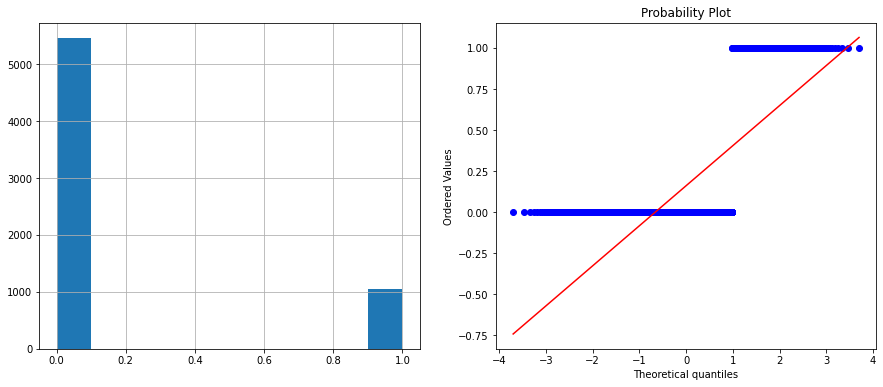

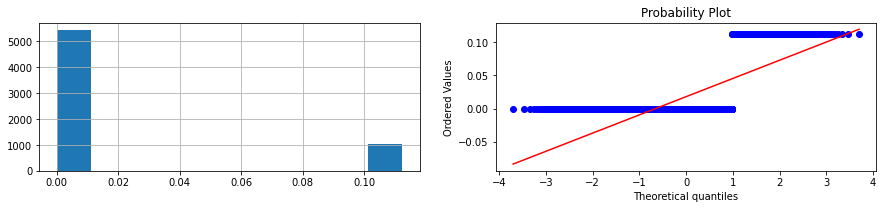

In [33]:
column = ['bruises','gill-spacing','gill-size','gill-color','stalk-root','population','habitat','stalk-surface']
boxcox_transformation(X,column)

#Applying Principal Component Analysis (PCA), this helps to handle multicollinearity in data as column stalk-surface has high multicollinearity.

In [34]:
pca = PCA(n_components = 7,random_state=42)
transformed_data = pca.fit_transform(X)
X = pd.DataFrame(data = transformed_data, columns = ['PCA1','PCA2','PCA3','PCA4','PCA5','PCA6','PCA7'])
X

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7
0,-2.852648,-1.174788,-0.435921,1.109816,0.779863,-0.271186,0.335035
1,-4.216727,4.535064,0.259920,-1.418893,-1.642736,-1.054551,-0.083650
2,4.990988,0.083099,-0.046806,0.869147,-1.742214,0.301655,0.394892
3,-4.847240,-2.128932,0.281968,0.636217,-0.499218,0.199307,-0.381923
4,-5.224548,1.626394,-1.210777,0.000590,-0.348756,0.238290,-0.068828
...,...,...,...,...,...,...,...
6494,-4.658229,-2.127793,-0.219805,-1.239353,-0.558993,0.345851,0.029950
6495,4.610432,0.836167,-0.051971,3.780697,-0.327814,0.961868,-0.777489
6496,2.472546,1.089214,3.592818,-1.447048,-0.326587,0.453362,0.442935
6497,5.356583,-1.328751,-1.216941,-0.036083,0.082190,-0.107148,-0.049556


In [35]:
print(pca.explained_variance_ratio_)
print(pca.noise_variance_)

[0.65682105 0.14943321 0.08379851 0.05614068 0.04071958 0.00848443
 0.00456146]
0.000814884859655534


In [36]:
X_train, X_test, y_train, y_test = tts(X, y, random_state=42,test_size=0.3)

In [37]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [38]:
def evaluate(model, X_test, y_test, X_train, y_train):
    y_pred = model.predict(X_test)
    errors = abs(y_pred - y_test)
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print(classification_report(y_test,y_pred))
    print(confusion_matrix(y_test,y_pred))
    print('Recall Score = ',recall_score(y_test, y_pred))
    print('Precision Score = ',precision_score(y_test, y_pred))

    return evaluate

In [39]:
def train_auc_roc_curve(model, X_test, y_test, X_train, y_train):
  y_pred = model.predict(X_test)
  print("roc curve :",roc_curve(y_test,y_pred))
  base_fpr,base_tpr,base_threshold = roc_curve(y_train, model.predict(X_train))
  plt.plot([0,1])
  plt.plot(base_fpr,base_tpr)
  print("auc score :",auc(base_fpr,base_tpr))

  return train_auc_roc_curve

In [40]:
def test_auc_ruc_curve(model, X_test, y_test):
  test_fpr, test_tpr, test_threshold = roc_curve(y_test,model.predict(X_test))
  test_auc = auc(test_fpr, test_tpr)
  print(test_auc)
  plt.plot([0,1])
  plt.plot(test_fpr, test_tpr)

  return test_auc_ruc_curve

#Applying Classification Models

#Logistic Regression

###Default Logistic Regression Model

In [41]:
base_model = LogisticRegression(random_state = 1)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test, X_train, y_train)

Average Error: 0.0851 degrees.
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       909
           1       0.92      0.92      0.92      1041

    accuracy                           0.91      1950
   macro avg       0.91      0.91      0.91      1950
weighted avg       0.91      0.91      0.91      1950

[[825  84]
 [ 82 959]]
Recall Score =  0.9212295869356388
Precision Score =  0.9194630872483222


roc curve : (array([0.        , 0.09240924, 1.        ]), array([0.        , 0.92122959, 1.        ]), array([2, 1, 0]))
auc score : 0.8917714860369769


<function __main__.train_auc_roc_curve>

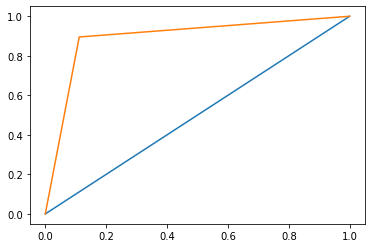

In [42]:
train_auc_roc_curve(base_model, X_test, y_test, X_train, y_train)

###Tuned Logistic Regression

In [43]:
logistic = LogisticRegression(random_state=42)

In [44]:
random_parameters = ({'C' : [0.001, 0.01, 0.1, 1.0],
                      'penalty' : ['l2'],
                      'solver' : ['lbfgs', 'newton-cg', 'saga'],
                      'max_iter' : [300,400,500,600,700,900,1000]})

random_search_logistic = RandomizedSearchCV(logistic, param_distributions= random_parameters, n_iter=60, cv=5)
random_search_logistic.fit(X,y)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=42,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=60, n_jobs=None,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1.0],
                                        'max_iter': [300, 400, 500, 600, 700,
                                                     900, 1000],
                                        'penalty': ['l2'],
           

In [45]:
random_search_logistic.best_estimator_

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=700,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [46]:
logistic = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
logistic.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [47]:
evaluate(logistic, X_test, y_test, X_train, y_train)

Average Error: 0.1815 degrees.
              precision    recall  f1-score   support

           0       0.86      0.72      0.79       909
           1       0.79      0.90      0.84      1041

    accuracy                           0.82      1950
   macro avg       0.83      0.81      0.81      1950
weighted avg       0.82      0.82      0.82      1950

[[659 250]
 [104 937]]
Recall Score =  0.9000960614793467
Precision Score =  0.7893850042123


<function __main__.evaluate>

roc curve : (array([0.       , 0.2750275, 1.       ]), array([0.        , 0.90009606, 1.        ]), array([2, 1, 0]))
auc score : 0.7894875067687785


<function __main__.train_auc_roc_curve>

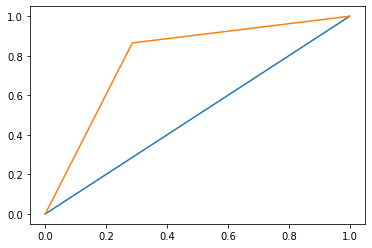

In [48]:
train_auc_roc_curve(logistic, X_test, y_test, X_train, y_train)

#Decision Tree Classifier

###Default Decision Tree Classifier

In [49]:
default_decision_tree_model = DecisionTreeClassifier(random_state=42)
default_decision_tree_model.fit(X_train, y_train)
base_accuracy = evaluate(default_decision_tree_model, X_test, y_test, X_train, y_train)

Average Error: 0.0000 degrees.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       909
           1       1.00      1.00      1.00      1041

    accuracy                           1.00      1950
   macro avg       1.00      1.00      1.00      1950
weighted avg       1.00      1.00      1.00      1950

[[ 909    0]
 [   0 1041]]
Recall Score =  1.0
Precision Score =  1.0


roc curve : (array([0., 0., 1.]), array([0., 1., 1.]), array([2, 1, 0]))
auc score : 1.0


<function __main__.train_auc_roc_curve>

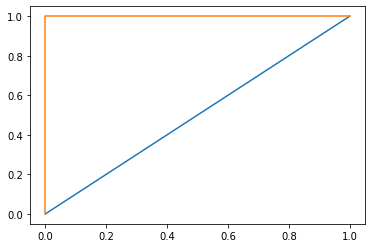

In [50]:
train_auc_roc_curve(default_decision_tree_model, X_test, y_test, X_train, y_train)

###Tuned Decision Tree Classifier

In [51]:
dtree_classifier = DecisionTreeClassifier(random_state=42)

In [52]:
#cost_complexity_pruning_path helps to find different ccp values which will be later used in random search for choosing the best one.
path = dtree_classifier.cost_complexity_pruning_path(X_train, y_train)
alphas = path['ccp_alphas']
alphas

array([0.        , 0.00065791, 0.00128627, 0.0012999 , 0.00131643,
       0.00164871, 0.00200484, 0.00216567, 0.00242478, 0.00250218,
       0.00265558, 0.00294084, 0.00398547, 0.0040698 , 0.00442573,
       0.00492386, 0.00607681, 0.0063336 , 0.01307759, 0.02013103,
       0.02145162, 0.02199723, 0.02350558, 0.04694003, 0.04712345,
       0.05036879, 0.18700521])

In [53]:
random_dtree_parameters = ({'ccp_alpha' : alphas,
                             'criterion' : ['gini','entropy'],
                            'splitter' : ['best','random'],
                            'max_depth' : [8,10,12,15,20,24,32],
                            'min_samples_leaf' : [2,3,5],
                            'max_features' : ['auto', 'sqrt', 'log2']})

random_search_dtree = RandomizedSearchCV(dtree_classifier, param_distributions= random_dtree_parameters, n_iter=60, cv=5)
random_search_dtree.fit(X,y)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=42,
            

In [54]:
random_search_dtree.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0012862694371117793, class_weight=None,
                       criterion='entropy', max_depth=20, max_features='sqrt',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=42, splitter='best')

In [55]:
dtree_classifier = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=12, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')
dtree_classifier.fit(X,y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=12, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [56]:
evaluate(dtree_classifier, X_test, y_test, X_train, y_train)

Average Error: 0.3579 degrees.
              precision    recall  f1-score   support

           0       0.61      0.67      0.63       909
           1       0.68      0.62      0.65      1041

    accuracy                           0.64      1950
   macro avg       0.64      0.64      0.64      1950
weighted avg       0.65      0.64      0.64      1950

[[606 303]
 [395 646]]
Recall Score =  0.6205571565802114
Precision Score =  0.6807165437302424


<function __main__.evaluate>

roc curve : (array([0.        , 0.33333333, 1.        ]), array([0.        , 0.62055716, 1.        ]), array([2, 1, 0]))
auc score : 0.6309842770944536


<function __main__.train_auc_roc_curve>

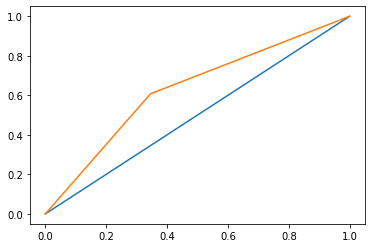

In [57]:
train_auc_roc_curve(dtree_classifier, X_test, y_test, X_train, y_train)

#Using Stratified Test Data

In [58]:
stratified_test_data.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
4632,x,y,g,f,f,f,c,b,p,e,b,k,k,p,n,p,w,o,l,h,y,d
3444,x,s,w,f,c,f,c,n,u,e,b,s,s,w,w,p,w,o,p,n,s,d
1209,x,f,w,f,n,f,w,b,p,t,e,s,s,w,w,p,w,o,e,n,s,g
6880,f,s,e,f,f,f,c,n,b,t,?,k,s,w,w,p,w,o,e,w,v,p
4542,x,f,y,f,f,f,c,b,g,e,b,k,k,p,n,p,w,o,l,h,y,g


In [59]:
le = LabelEncoder()
stratified_test_data[["cap-shape",'cap-surface','cap-color','bruises','odor','gill-attachment','gill-spacing','gill-size','gill-color','stalk-shape','stalk-root','stalk-surface-above-ring','stalk-surface-below-ring','stalk-color-above-ring','stalk-color-below-ring','veil-type','veil-color','ring-number','ring-type','spore-print-color','population','habitat']] = stratified_test_data[["cap-shape",'cap-surface','cap-color','bruises','odor','gill-attachment','gill-spacing','gill-size','gill-color','stalk-shape','stalk-root','stalk-surface-above-ring','stalk-surface-below-ring','stalk-color-above-ring','stalk-color-below-ring','veil-type','veil-color','ring-number','ring-type','spore-print-color','population','habitat']].apply(le.fit_transform)

In [60]:
#DELETING ALL THE UNWANTED COLUMNS AND ALSO DELETING THE 'veil-type' COLUMN AS IT IS USELESS FOR US
stratified_test_data.drop(['cap-shape','cap-color','veil-type','veil-color', 'spore-print-color', 'ring-type'],1,inplace=True)

In [61]:
stratified_test_data.head()

,cap-surface,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,ring-number,population,habitat
4632,3,0,2,1,0,0,7,0,1,1,1,6,4,1,5,0
3444,2,0,1,1,0,1,9,0,1,2,2,7,7,1,3,0
1209,0,0,5,1,1,0,7,1,3,2,2,7,7,1,3,1
6880,2,0,2,1,0,1,0,1,0,1,2,7,7,1,4,4
4542,0,0,2,1,0,0,2,0,1,1,1,6,4,1,5,1


In [62]:
stratified_test_data.columns

Index(['cap-surface', 'bruises', 'odor', 'gill-attachment', 'gill-spacing',
       'gill-size', 'gill-color', 'stalk-shape', 'stalk-root',
       'stalk-surface-above-ring', 'stalk-surface-below-ring',
       'stalk-color-above-ring', 'stalk-color-below-ring', 'ring-number',
       'population', 'habitat'],
      dtype='object')

In [63]:
stratified_test_data['stalk-surface'] = stratified_test_data['stalk-surface-above-ring'] + stratified_test_data['stalk-surface-below-ring']
stratified_test_data['stalk-surface']

4632    2
3444    4
1209    4
6880    3
4542    2
       ..
7554    4
3198    4
3850    4
1965    4
5718    4
Name: stalk-surface, Length: 1625, dtype: int64

In [64]:
stratified_test_data.drop(['stalk-color-above-ring', 'stalk-color-below-ring','stalk-surface-above-ring','stalk-surface-below-ring','cap-surface','odor', 'gill-attachment', 'stalk-shape', 'ring-number'],1,inplace=True)

In [65]:
print("Remaining Columns are \n: {}". format(stratified_test_data.columns))

Remaining Columns are 
: Index(['bruises', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-root',
       'population', 'habitat', 'stalk-surface'],
      dtype='object')


1.8014604612780831



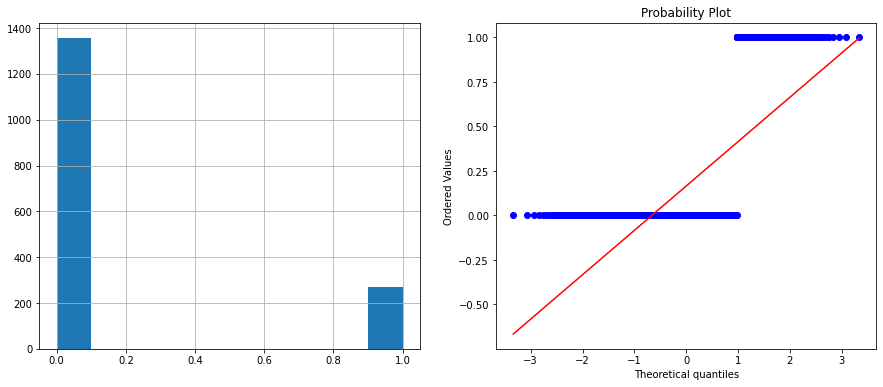

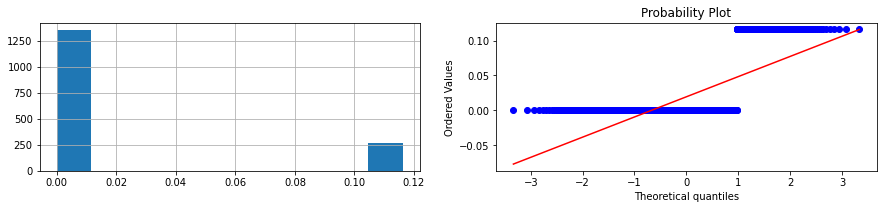

In [66]:
column = ['bruises','gill-spacing','gill-size','gill-color','stalk-root','population','habitat','stalk-surface']
boxcox_transformation(stratified_test_data,column)

In [67]:
test_pca = PCA(n_components = 7,random_state=42)
transformed_test_data = test_pca.fit_transform(stratified_test_data)
test_x = pd.DataFrame(data = transformed_test_data, columns = ['PCA1','PCA2','PCA3','PCA4','PCA5','PCA6','PCA7'])
test_x

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7
0,2.247162,-1.563533,-0.363378,1.787319,0.351873,0.120196,0.302329
1,4.361829,-0.826292,0.315885,-0.377385,-0.958475,1.140627,0.023016
2,2.557412,0.162623,1.103957,-0.871974,1.025279,0.427906,0.699505
3,-5.182465,1.500546,-1.145364,0.006384,-0.340016,0.237908,-0.065046
4,-2.763645,-1.195125,-0.293174,1.181323,0.820016,-0.284174,0.331752
...,...,...,...,...,...,...,...
1620,-4.812741,-0.412977,-0.825843,-1.017020,-0.474449,0.304792,0.107282
1621,5.457161,-1.001537,-0.528393,-0.100019,-0.388300,-0.137000,-0.117704
1622,0.562879,-1.871111,-0.912417,-0.495427,0.527722,-0.512740,-0.047564
1623,2.557412,0.162623,1.103957,-0.871974,1.025279,0.427906,0.699505


In [68]:
sc = StandardScaler()
test_x = sc.fit_transform(test_x)

In [69]:
print(test_x)

[[ 0.62057514 -0.9221578  -0.27473408 ...  0.39008353  0.2913565
   0.98657963]
 [ 1.20456053 -0.48733958  0.23882667 ... -1.06255652  2.76490016
   0.07510604]
 [ 0.70625379  0.09591385  0.83465274 ...  1.13661501  1.0372508
   2.28267214]
 ...
 [ 0.15544439 -1.10356481 -0.68983793 ...  0.58502746 -1.24289018
  -0.15521353]
 [ 0.70625379  0.09591385  0.83465274 ...  1.13661501  1.0372508
   2.28267214]
 [ 0.66729331 -0.06134295  0.11945016 ... -0.64334598 -0.97752064
  -0.50029449]]


##Default Logistic Regression

0.9144101730057732


<function __main__.test_auc_ruc_curve>

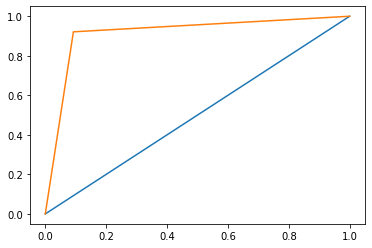

In [70]:
test_auc_ruc_curve(base_model, X_test, y_test)

##Tuned Logistic Regression

0.8125342793645358


<function __main__.test_auc_ruc_curve>

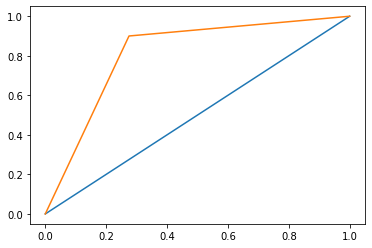

In [71]:
test_auc_ruc_curve(logistic, X_test, y_test)

##Default Decision tree classifier

1.0


<function __main__.test_auc_ruc_curve>

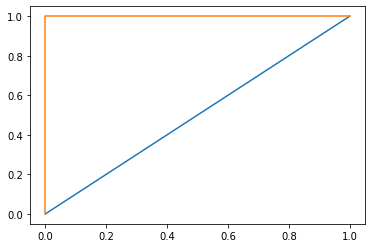

In [72]:
test_auc_ruc_curve(default_decision_tree_model, X_test, y_test)

##Tuned Decision Tree classifier

0.6436119116234391


<function __main__.test_auc_ruc_curve>

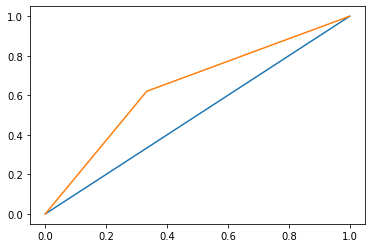

In [73]:
test_auc_ruc_curve(dtree_classifier, X_test, y_test)